In [1]:
from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import IndicatorBox, LeastSquares, BlockFunction
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D
import matplotlib.pyplot as plt
import numpy as np
import sys
cil_path = '/home/user/CILworkspace/CIL/'
fun_path = 'Wrappers/Python/cil/optimisation/functions'
sys.path.append(cil_path + fun_path)

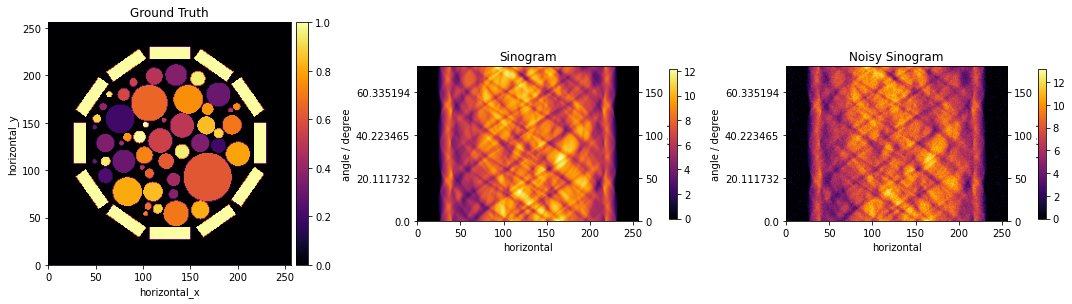

In [2]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device='gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
noise_scale = 1

gaussian_var = 0.5 * noise_scale
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size=ag.shape)

noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array < 0] = 0

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title=['Ground Truth', 'Sinogram', 'Noisy Sinogram'], num_cols=3, cmap='inferno')

ISTA setting up
ISTA configured


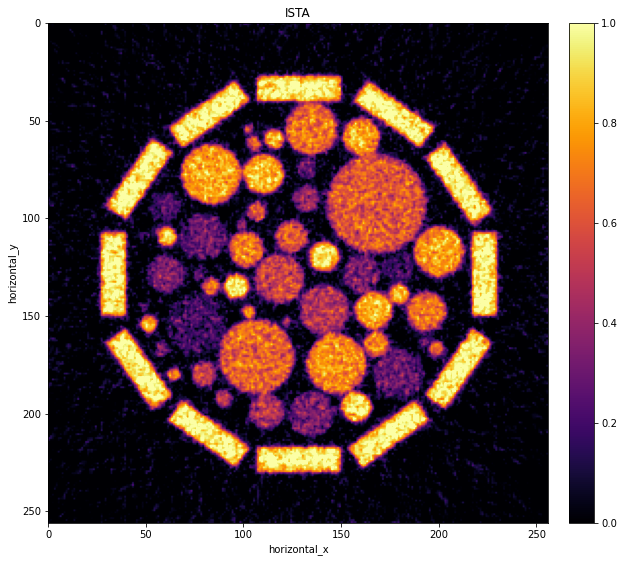

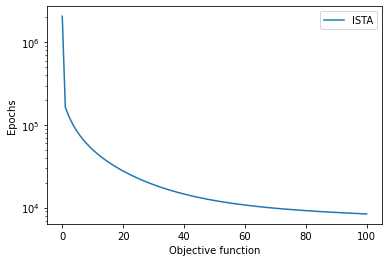

In [3]:
from cil.optimisation.algorithms.FISTA import ISTA

# ISTA
num_epochs = 100
f_gd = LeastSquares(A, noisy_sino)
initial = ig.allocate(0)
step_size = 1 / f_gd.L
g_fun = IndicatorBox(lower=0)
ista = ISTA(initial=initial, f=f_gd, g=g_fun,
                     step_size=step_size, update_objective_interval=1,
                     max_iteration=1000)
ista.run(num_epochs, verbose=0)

show2D([ista.solution],
       title=["ISTA"],
       origin="upper",
       fix_range=(0,1), num_cols=2,
       cmap='inferno')

plt.figure()
plt.semilogy(ista.objective, label="ISTA")
plt.legend()
plt.ylabel('Epochs')
plt.xlabel('Objective function')
plt.show()
np.save("ISTA.npy",ista.objective)